!pip install pandas
!pip install pyspark
!pip install imblearn
!pip install pyarrow
!pip install matplotlib
!pip intsall numpy

In [254]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer
from pyspark.sql.functions import col, asc,desc
from pyspark.sql.functions import regexp_replace
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from imblearn.over_sampling import SMOTE
from pyspark.sql.types import StringType, DoubleType
from pyspark.ml.classification import RandomForestClassifier

spark=SparkSession.builder.appName('Data Processing and Classification using Spark and SMOTE').getOrCreate()
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

In [255]:
df_pyspark=spark.read.csv('bank-additional-full.csv',header=True,inferSchema=True)

In [256]:
#Original schema of Data
df_pyspark.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp.var.rate: double (nullable = true)
 |-- cons.price.idx: double (nullable = true)
 |-- cons.conf.idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr.employed: double (nullable = true)
 |-- y: string (nullable = true)



In [258]:
#renaming columns having '.' with '_' to avoid clash in spark
def rename_cols(df):
    for column in df.columns:
        new_column = column.replace('.','_')
        df = df.withColumnRenamed(column, new_column)
    return df

df_pyspark = rename_cols(df_pyspark)

columns = ['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome','y']
print(df_pyspark.count(),df_pyspark.na.drop(how="any").count())
print('No null values present')

41188 41188
No null values present


In [259]:
# Checking numeric data's description for better understanding
#dbl_cols = [f.name for f in df_pyspark.schema.fields if isinstance(f.dataType, DoubleType)]
df_pyspark.select('age','campaign','pdays','previous','emp_var_rate','cons_price_idx',
                  'cons_conf_idx','euribor3m','nr_employed').describe().show(n=5, truncate=False, vertical=True)

-RECORD 0-----------------------------
 summary        | count               
 age            | 41188               
 campaign       | 41188               
 pdays          | 41188               
 previous       | 41188               
 emp_var_rate   | 41188               
 cons_price_idx | 41188               
 cons_conf_idx  | 41188               
 euribor3m      | 41188               
 nr_employed    | 41188               
-RECORD 1-----------------------------
 summary        | mean                
 age            | 40.02406040594348   
 campaign       | 2.567592502670681   
 pdays          | 962.4754540157328   
 previous       | 0.17296299893172767 
 emp_var_rate   | 0.08188550063178392 
 cons_price_idx | 93.57566436828918   
 cons_conf_idx  | -40.50260027191787  
 euribor3m      | 3.6212908128585366  
 nr_employed    | 5167.035910944004   
-RECORD 2-----------------------------
 summary        | stddev              
 age            | 10.421249980934057  
 campaign       | 2.77001

In [260]:
#Data Transformation begins
df_pyspark = df_pyspark.filter(df_pyspark['duration']>0)
df_pyspark.count() # duration = 0 means y = 0 regardless of other attributes hence dropping these tuple
#to avoid false information

df_pyspark = df_pyspark.drop('duration') #if the call happens we already know the answer of the customer, 
#hence to make it a realisitic predictive model we are dropping this column.


In [261]:
def number_unknowns(df):
    print("No of unknowns:")
    for column in columns:
        print(column,df.filter(df[column]=='unknown').count())
    return

number_unknowns(df_pyspark)# As no. of unknown's percentage is low, there is no need to drop the columns and unknown will
# treated as a separate category

No of unknowns:
job 330
marital 80
education 1731
default 8597
housing 990
loan 990
contact 0
month 0
day_of_week 0
poutcome 0
y 0


In [262]:
temp = df_pyspark.filter(df_pyspark['job'] == 'unknown')
temp = temp.groupBy('education').count()
temp.sort(col('count').desc()).show() 

temp = df_pyspark.filter(df_pyspark['education'] == 'unknown')
temp = temp.groupBy('job').count()
temp.sort(col('count').desc()).show() #when job is unknown most likely the job is blue-collar hence the 
#unknowns in job are imputed

temp = df_pyspark.filter(df_pyspark['job'] == 'blue-collar')
temp = temp.groupBy('education').count()
temp.sort(col('count').desc()).show() #when education is unknown most likely the education is basic.9y hence the unknowns 
#in education are imputed with basic.9y

+-------------------+-----+
|          education|count|
+-------------------+-----+
|            unknown|  131|
|           basic.4y|   52|
|  university.degree|   45|
|        high.school|   37|
|           basic.9y|   31|
|           basic.6y|   22|
|professional.course|   12|
+-------------------+-----+

+-------------+-----+
|          job|count|
+-------------+-----+
|  blue-collar|  454|
|       admin.|  249|
|   technician|  212|
|      student|  167|
|     services|  150|
|      unknown|  131|
|   management|  123|
|      retired|   98|
| entrepreneur|   57|
|    housemaid|   42|
|self-employed|   29|
|   unemployed|   19|
+-------------+-----+

+-------------------+-----+
|          education|count|
+-------------------+-----+
|           basic.9y| 3622|
|           basic.4y| 2318|
|           basic.6y| 1426|
|        high.school|  877|
|            unknown|  454|
|professional.course|  453|
|  university.degree|   94|
|         illiterate|    8|
+-------------------+-----+



In [264]:
#Unknowns imputed in job
df_pyspark = df_pyspark.withColumn('job', regexp_replace('job', 'unknown', 'blue-collar'))
df_pyspark.groupBy('job').count().show()

#Unknowns imputed in education
df_pyspark = df_pyspark.withColumn('education', regexp_replace('education', 'unknown', 'basic.9y'))
df_pyspark.groupBy('education').count().show()

#Unknowns removed

+-------------+-----+
|          job|count|
+-------------+-----+
|   management| 2923|
|      retired| 1720|
|self-employed| 1421|
|      student|  875|
|  blue-collar| 9582|
| entrepreneur| 1456|
|       admin.|10421|
|   technician| 6743|
|     services| 3969|
|    housemaid| 1060|
|   unemployed| 1014|
+-------------+-----+

+-------------------+-----+
|          education|count|
+-------------------+-----+
|        high.school| 9513|
|           basic.6y| 2292|
|professional.course| 5243|
|  university.degree|12167|
|         illiterate|   18|
|           basic.4y| 4176|
|           basic.9y| 7775|
+-------------------+-----+



In [265]:
#Converting categorcial string columns into numerical ones
def convert_categorical(df,inputCol,new_column):
    indexer = StringIndexer(inputCol=column, outputCol=new_column)
    indexed = indexer.fit(df).transform(df)
    return indexed


columns_final = ['Jobf','Maritalf','Educationf','Defaultf','Housingf','Loanf','Contactf',
                 'Monthf','Day_of_weekf','Poutcomef','label']

i = 0
for column in columns:
    new_column = columns_final[i]
    i+=1
    df_pyspark = convert_categorical(df_pyspark,column,new_column)
    
df_pyspark.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp_var_rate: double (nullable = true)
 |-- cons_price_idx: double (nullable = true)
 |-- cons_conf_idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr_employed: double (nullable = true)
 |-- y: string (nullable = true)
 |-- Jobf: double (nullable = false)
 |-- Maritalf: double (nullable = false)
 |-- Educationf: double (nullable = false)
 |-- Defaultf: double (nullable = false)
 |-- Housingf: double (nullable = fal

In [269]:
#Converting our features into one vector for model training
featureassembler=VectorAssembler(inputCols=['age','Jobf','Maritalf','campaign','pdays','previous','emp_var_rate',
 'cons_price_idx','cons_conf_idx','euribor3m',
 'nr_employed','Educationf','Defaultf','Housingf','Loanf','Contactf','Monthf','Day_of_weekf','Poutcomef'],
                                 outputCol="Independent Features")
output=featureassembler.transform(df_pyspark)
finalized_data=output.select("Independent Features","label")
finalized_data.show()

+--------------------+-----+
|Independent Features|label|
+--------------------+-----+
|[56.0,8.0,0.0,1.0...|  0.0|
|[57.0,3.0,0.0,1.0...|  0.0|
|[37.0,3.0,0.0,1.0...|  0.0|
|[40.0,0.0,0.0,1.0...|  0.0|
|[56.0,3.0,0.0,1.0...|  0.0|
|[45.0,3.0,0.0,1.0...|  0.0|
|[59.0,0.0,0.0,1.0...|  0.0|
|[41.0,1.0,0.0,1.0...|  0.0|
|[24.0,2.0,1.0,1.0...|  0.0|
|[25.0,3.0,1.0,1.0...|  0.0|
|[41.0,1.0,0.0,1.0...|  0.0|
|[25.0,3.0,1.0,1.0...|  0.0|
|[29.0,1.0,1.0,1.0...|  0.0|
|[57.0,8.0,2.0,1.0...|  0.0|
|[35.0,1.0,0.0,1.0...|  0.0|
|[54.0,5.0,0.0,1.0...|  0.0|
|[35.0,1.0,0.0,1.0...|  0.0|
|[46.0,1.0,0.0,1.0...|  0.0|
|[50.0,1.0,0.0,1.0...|  0.0|
|[39.0,4.0,1.0,1.0...|  0.0|
+--------------------+-----+
only showing top 20 rows



In [285]:
a = finalized_data.filter(df_pyspark['label']==1).count()
b = finalized_data.filter(df_pyspark['label']==0).count()

print('The no. of negative and positive samples are ',a,b)
print('This shows that the data is clearly unbalanced')

The no. of negative and positive samples are  4640 36544
This shows that the data is clearly unbalanced


In [286]:
#Training the model
train_data,test_data=finalized_data.randomSplit([0.75,0.25])
regressor=LogisticRegression(featuresCol='Independent Features', labelCol='label')
regressor=regressor.fit(train_data)

c:\users\vaibh\pycharmprojects\spark\venv\lib\site-packages\pyspark\sql\context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


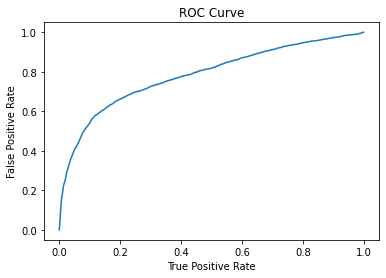

Training set areaUnderROC: 0.7840975423370281


In [287]:
trainingSummary = regressor.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

c:\users\vaibh\pycharmprojects\spark\venv\lib\site-packages\pyspark\sql\context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


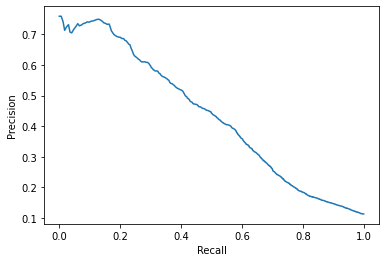

In [288]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [289]:
lr_model = regressor.transform(test_data)

In [290]:
temp1 = lr_model.filter(lr_model['label']==1.0).count()
temp1
temp2 = lr_model.filter(lr_model['prediction']==1.0).count()
temp2

print('True positive prediction for Logistic Regression without over-sampling is ',temp2/temp1*100)

True positive prediction for Logistic Regression without over-sampling is  36.79577464788733


In [291]:
evaluator = BinaryClassificationEvaluator()
print('Test Area under ROC for Logistic Regression without over-sampling is ', evaluator.evaluate(lr_model)*100)

Test Area under ROC for Logistic Regression without over-sampling is  79.48890650216399


In [292]:
accuracy = lr_model.filter(lr_model.label == lr_model.prediction).count() / float(lr_model.count())
print(" Model Accuracy : ",accuracy)
print(" This value is misleading because majority of the samples have 0 as their label")

 Model Accuracy :  0.9030139103554868
 This value is misleading because majority of the samples have 0 as their label


In [293]:
#Applying SMOTE(Oversampling to balance the minority classes)
features = df_pyspark.select(['age','Jobf','Maritalf','campaign','pdays','previous','emp_var_rate',
 'cons_price_idx','cons_conf_idx','euribor3m',
 'nr_employed','Educationf','Defaultf','Housingf','Loanf','Contactf','Monthf','Day_of_weekf','Poutcomef']).toPandas()
labels = df_pyspark.select('label').toPandas()

In [294]:
\

In [295]:
labels
features['label'] = labels.values
features = spark.createDataFrame(features) 

In [304]:
featureassembler=VectorAssembler(inputCols=['age','Jobf','Maritalf','campaign','pdays','previous','emp_var_rate',
 'cons_price_idx','cons_conf_idx','euribor3m',
 'nr_employed','Educationf','Defaultf','Housingf','Loanf','Contactf','Monthf','Day_of_weekf','Poutcomef'],outputCol="Independent Features")
output=featureassembler.transform(features)
finalized_data_smote=output.select("Independent Features","label")

train_data_smote,test_data_smote=finalized_data_smote.randomSplit([0.75,0.25])
regressor_smote=LogisticRegression(featuresCol='Independent Features', labelCol='label')
regressor_smote=regressor_smote.fit(train_data_smote)

c:\users\vaibh\pycharmprojects\spark\venv\lib\site-packages\pyspark\sql\context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


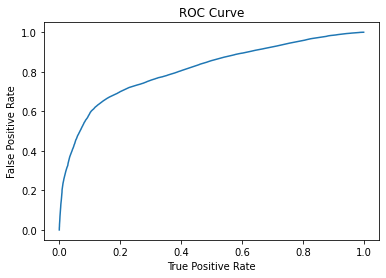

Training set areaUnderROC for Logistic Regression with SMOTE = 0.8096898501159091


In [305]:
trainingSummary = regressor_smote.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC for Logistic Regression with SMOTE = ' + str(trainingSummary.areaUnderROC))

c:\users\vaibh\pycharmprojects\spark\venv\lib\site-packages\pyspark\sql\context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


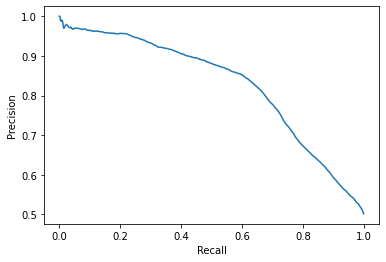

In [306]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [302]:
lr_model_smote = regressor_smote.transform(test_data_smote)
evaluator = BinaryClassificationEvaluator()
print('Test Area under ROC', evaluator.evaluate(lr_model_smote))

Test Area under ROC 0.8092361232353109


In [303]:
accuracy = lr_model_smote.filter(lr_model_smote.label == lr_model_smote.prediction).count() / float(lr_model_smote.count())
print("Accuracy : ",accuracy)

Accuracy :  0.7537761897027774


In [308]:
temp1 = lr_model_smote.filter(lr_model_smote['label']==1.0).count()
temp1
temp2 = lr_model_smote.filter(lr_model_smote['prediction']==1.0).count()
temp2

print('True positive prediction for Logistic Regression with over-sampling is ',temp2/temp1*100)
print('which is around 2.25X better than the model without oversampling')

True positive prediction for Logistic Regression with over-sampling is  81.92150975766673
which is around 2.25X better than the model without oversampling


In [309]:
#Using RandomForest for Classification for Alternate
rf = RandomForestClassifier(featuresCol = 'Independent Features', labelCol = 'label')
rfModel = rf.fit(train_data)
predictions = rfModel.transform(test_data)

In [313]:
#ROC is a probability curve and AUC represents degree or measure of separability. 
#ROC tells how much model is capable of distinguishing between classes.
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC with RandomForest without oversampling " + 
      str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})*100))
accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(predictions.count())
print("Accuracy : ",accuracy*100)


Test Area Under ROC with RandomForest without oversampling 79.56201974215082
Accuracy :  90.1275115919629


In [314]:
temp1 = predictions.filter(predictions['label']==1.0).count()
temp2 = predictions.filter(predictions['prediction']==1.0).count()

print('True positive percentage with RandomForest without over sampling ',temp2/temp1*100)

True positive percentage with RandomForest without over sampling  26.408450704225352


In [315]:
#Testing with Oversampled data
rf = RandomForestClassifier(featuresCol = 'Independent Features', labelCol = 'label')
rfModel = rf.fit(train_data_smote)
predictions = rfModel.transform(test_data_smote)

In [317]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC with RandomForest with oversampling " + str(evaluator.evaluate(predictions,
                                                                {evaluator.metricName: "areaUnderROC"})))
accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(predictions.count())
print("Accuracy : ",accuracy*100)

Test Area Under ROC with RandomForest with oversampling 0.8976673888029654
Accuracy :  81.81818181818183


In [318]:
temp1 = predictions.filter(predictions['label']==1.0).count()
temp2 = predictions.filter(predictions['prediction']==1.0).count()

print('True positive percentage for RandomForest with oversampling is ',temp2/temp1*100)

True positive percentage for RandomForest with oversampling is  89.11342894393742
